In [1]:
# ms-python.python added
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks/report'))
    print(os.getcwd())
except:
    pass


/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()

In [3]:
df = pd.read_csv('../../data/processed/train.csv')
df.head()

,id,start (sec),end (sec),description,length
0,AO8RW,0.0,6.9,a person is putting a book on a shelf.,33.67
1,Y6R7T,20.8,30.0,person begins to play on a phone.,29.42
2,Y6R7T,20.8,30.0,person start playing on their phone.,29.42
3,Y6R7T,7.3,17.3,person pouring it into a glass.,29.42
4,Y6R7T,7.3,17.3,the person pours some water into the glass.,29.42


In [4]:
# remove miss labeled data

indices = np.where(df['end (sec)'] - df['start (sec)'] < 0)
df = df.drop(index=indices[0])

# Distribution of normalized start and moment duration

/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'moment duration')

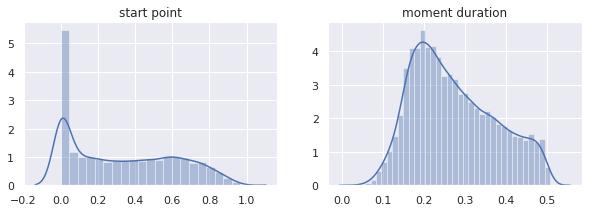

In [5]:
f, axes = plt.subplots(1, 2, figsize=(10, 3))
_ = sns.distplot(df['start (sec)']/df['length'], ax=axes[0])
axes[0].set_title('start point')
_ = sns.distplot((df['end (sec)'] - df['start (sec)'])/df['length'], ax=axes[1])
axes[1].set_title('moment duration')


In [6]:
df['start (norm)'] = df['start (sec)']/df['length']
df['end (norm)'] = df['end (sec)']/df['length']
df['moment duration (norm)'] = df['end (norm)'] - df['start (norm)']

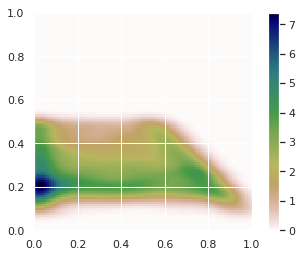

In [191]:
start = df['start (norm)'].values
duration = df['moment duration (norm)'].values
kernel = gaussian_kde(np.vstack([start, duration]))
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
plt.colorbar()

 # Candidate moment proposal

 momentのstart timeとdurationの確率密度関数をカーネル密度推定してランダムにサンプリングする
 
 サンプリングしたmomentを確率密度関数の値でランキングする

In [239]:
class SegmentGeneratorKDE(object):
    def __init__(self):
        self.kernel = None

    def fit(self, df):
        start = df['start (norm)'].values
        duration = df['moment duration (norm)'].values
        self.kernel = gaussian_kde(np.vstack([start, duration]))
        self.start_max = df['start (norm)'].max()
        self.duration_min = df['moment duration (norm)'].min()

    def sample(self, n):
        samples = self.kernel.resample(n)
        likelifood = self.kernel(samples)
        
        start = samples[0, :]
        duration = samples[1, :]
        
        start = np.clip(start, 0, self.start_max)
        duration = np.clip(duration, self.duration_min, None)
        
        duration = np.min(np.vstack([duration, 1 - start]), axis=0)
        
        samples = np.hstack([start[:, None], duration[:, None]])
        
        return samples, likelifood

/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'moment duration (sampled)')

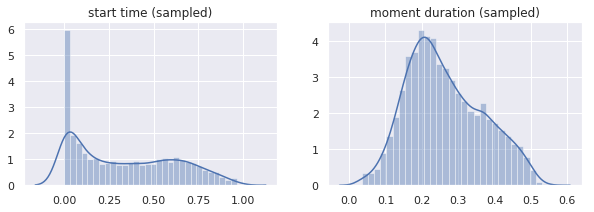

In [240]:
sg = SegmentGeneratorKDE()
sg.fit(df)

samples, _ = sg.sample(5000)
samples = np.asarray(samples)

f, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.distplot(samples[:, 0], bins=30, ax=axes[0])
axes[0].set_title("start time (sampled)")

sns.distplot(samples[:, 1], bins=30, ax=axes[1])
axes[1].set_title("moment duration (sampled)")


 だいたいtraining setの分布をmimicできてるっぽい

 # Baseline by random segment sampling

In [241]:


def iou(pred_s, pred_e, true_s, true_e):
    assert pred_s < pred_e, "predicted value invalid"
    assert true_s < true_e, "true value invalid"

    union = min(pred_s, true_s), max(pred_e, true_e)
    intersection = max(pred_s, true_s), min(pred_e, true_e)

    if intersection[0] > intersection[1]:
        return 0

    iou_val = (intersection[1] - intersection[0]) / (union[1] - union[0])
    return iou_val



In [242]:
test_df = pd.read_csv('../../data/processed/test.csv')
test_df.head()

,id,start (sec),end (sec),description,length
0,3MSZA,24.3,30.4,person turn a light on.,30.96
1,3MSZA,24.3,30.4,person flipped the light switch near the door.,30.96
2,3MSZA,24.3,30.4,person turn the light switch on.,30.96
3,3MSZA,24.3,30.4,person is playing with the switch for the light.,30.96
4,AMT7R,4.3,12.5,a person is putting a picture onto the wall.,30.08


In [243]:
pred, val = sg.sample(len(test_df)*5)
pred[:, 1] = pred[:, 0] + pred[:, 1]  # convert (start, duration) -> (start, end)
pred *= np.repeat(test_df['length'].values.reshape(-1, 1), 5)[:, None] # original scale (sec.)

pred = np.split(pred, len(test_df))
val = np.split(val, len(test_df))

gt = test_df[['start (sec)', 'end (sec)']].values

# compute R@1

res = []
for p_item, v_item, gt_item in zip(pred, val, gt):
    top_1 = p_item[np.argmax(v_item)]
    iou_val = iou(top_1[0], top_1[1], gt_item[0], gt_item[1])
    res.append(iou_val)
    
print("R@1 IoU>.5: %.2f" % ((np.asarray(res) > 0.5).mean()*100))
print("R@1 IoU>.7: %.2f" % ((np.asarray(res) > 0.7).mean()*100))

# compute R@5

res = []
for p_item, gt_item in zip(pred, gt):
    iou_val = max([iou(p_item[j, 0], p_item[j, 1], gt_item[0], gt_item[1]) for j in range(5)])
    res.append(iou_val)

print("R@5 IoU>.5: %.2f" % ((np.asarray(res) > 0.5).mean()*100))
print("R@5 IoU>.7: %.2f" % ((np.asarray(res) > 0.7).mean()*100))

R@1 IoU>.5: 20.46
R@1 IoU>.7: 7.55
R@5 IoU>.5: 58.09
R@5 IoU>.7: 26.69


In [229]:
results = {
    'R@1 IoU>.5': [],
    'R@1 IoU>.7': [],
    'R@5 IoU>.5': [],
    'R@5 IoU>.7': [],
}

for _ in range(100):
    
    pred, val = sg.sample(len(test_df)*5)
    pred[:, 1] = pred[:, 0] + pred[:, 1]  # convert (start, duration) -> (start, end)
    pred *= np.repeat(test_df['length'].values.reshape(-1, 1), 5)[:, None] # original scale (sec.)

    pred = np.split(pred, len(test_df))
    val = np.split(val, len(test_df))

    gt = test_df[['start (sec)', 'end (sec)']].values

    # compute R@1

    res = []
    for p_item, v_item, gt_item in zip(pred, val, gt):
        top_1 = p_item[np.argmax(v_item)]
        iou_val = iou(top_1[0], top_1[1], gt_item[0], gt_item[1])
        res.append(iou_val)

    results['R@1 IoU>.5'].append((np.asarray(res) > 0.5).mean()*100)
    results['R@1 IoU>.7'].append((np.asarray(res) > 0.7).mean()*100)
    
    # compute R@5

    res = []
    for p_item, gt_item in zip(pred, gt):
        iou_val = max([iou(p_item[j, 0], p_item[j, 1], gt_item[0], gt_item[1]) for j in range(5)])
        res.append(iou_val)
    
    results['R@5 IoU>.5'].append((np.asarray(res) > 0.5).mean()*100)
    results['R@5 IoU>.7'].append((np.asarray(res) > 0.7).mean()*100)

/home/otani_mayu/miniconda3/envs/py36chainer/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


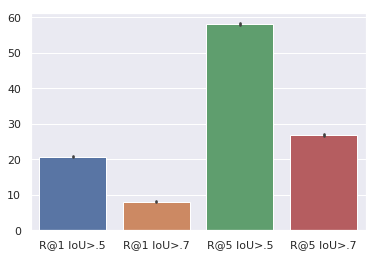

In [230]:
sns.barplot(data=pd.DataFrame(results), ci=100.)

In [232]:
pd.DataFrame(results).min()

R@1 IoU>.5    19.247312
R@1 IoU>.7     7.123656
R@5 IoU>.5    56.693548
R@5 IoU>.7    24.838710
dtype: float64

In [233]:
pd.DataFrame(results).mean()

R@1 IoU>.5    20.719624
R@1 IoU>.7     8.048925
R@5 IoU>.5    58.080108
R@5 IoU>.7    26.836290
dtype: float64

In [234]:
pd.DataFrame(results).max()

R@1 IoU>.5    22.204301
R@1 IoU>.7     9.193548
R@5 IoU>.5    60.000000
R@5 IoU>.7    28.817204
dtype: float64

max iou: 0.5


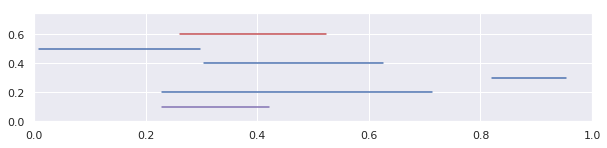

In [238]:
# show example
i = np.random.randint(len(test_df))
true_s, true_e = gt[i]
l = test_df['length'][i]
plt.figure(figsize=(10, 2))
plt.axhline(0.1, true_s/l, true_e/l, color='m')
plt.xlim((0, 1))
plt.ylim((0, .75))

p_item = pred[i]
# p_item = p_item.reshape(-1, 2)
offset = 0.2
iou_val = []
lines = []
for pred_s, pred_e in p_item:
    line = plt.axhline(offset, pred_s/l, pred_e/l, color='b')
    offset += 0.1
    iou_val.append(iou(pred_s, pred_e, true_s, true_e))
    lines.append(line)
print('max iou: %.1f' % max(iou_val))
if max(iou_val) > 0:
    lines[np.argmax(iou_val)].set_color('r')


 # ベースラインについて

 ## Random (sliding window)

 従来研究のRandomベースライン

 multi-scale temporal sliding window: {64, 128, 256, 512} frames and 80% overlap

 生成されたtemporal widowをランダムに選んだベースライン

 ## Random (KDE)

 segmentのstart timeとdurationをの確率密度関数をKDEで推定
 
 ランダムにサンプリング、生成されたサンプルをそのサンプル点での確率密度関数の値で並び替え


 ## 結果

 | method                             | R@1 IoU=0.5 | R@1 IoU=0.7 | R@5 IoU=0.5 | R@5 IoU=0.7 |
 |------------------------------------|------------:|------------:|------------:|------------:|
 | Random (sliding window)            |        8.51 |        3.03 |       37.12 |       14.06 |
 | Random (KDE)                       |       20.72 |        8.05 |       58.08 |       26.84 |
 | CTRL (ICCV'17)                     |       21.42 |        7.15 |       59.11 |       26.91 |
 | MAN (CVPR'19)                      |       46.53 |       22.72 |       86.23 |       53.72 |

 CTRL (Tall: Temporal activity localization via language query, ICCV'17)はRandom (KDE)とそんなに変わらない
 
 ただし、ベースラインはrandomなので多少スコアは上下する

 Tall論文ではもっと単純なRandomベースラインと比較してたけどあまり意味のないベースラインかも（弱すぎベースライン）

 データにバイアスがあるのでちょっとprior入れてやるだけで割とスコアは上がる

 ## メモ

 Tallはsliding windowベースの手法。多分そこがスコアのボトルネック

 candidate proposalの生成は少なくともデータセットの分布が反映される方法でやった方がいい（学習ベースの手法）

 queryの中の特定のphrase (eg., first time, after) を考慮するだけで結構スコア上がるのでは？